In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
import os

import preprocess

# Define shared LSTM layers
def build_shared_lstm(input_shape):
    inputs = layers.Input(shape=(input_shape))
    x = layers.LSTM(32, return_sequences=True)(inputs)
    x = layers.LSTM(4, return_sequences=True)(x)
    # Flatten the output of the LSTM layers
    x = layers.Flatten()(x)
    return inputs, x

# Define task-specific fully connected layers
def task_specific_layers(shared_output):
    x = layers.Dense(32, activation='relu')(shared_output)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    return output

# Input shape (for example, time series length of 100 with 10 features)
input_shape = (240, 1)

# Define shared LSTM layers
inputs, shared_output = build_shared_lstm(input_shape)

# Define task-specific outputs
output_task_1 = task_specific_layers(shared_output)  # Task 1 
output_task_2 = task_specific_layers(shared_output)  # Task 2 
# output_task_3 = task_specific_layers(shared_output)  # Task 3 

# Create a model with multiple outputs
model = models.Model(inputs=inputs, outputs=[output_task_1, output_task_2])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0005,
                                                             decay_steps=1000,
                                                             decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

# Compile the model with task-specific losses and metrics
model.compile(optimizer=optimizer,
              loss=['mean_squared_error', 'mean_squared_error'])

target_contract = "GMWB"
target_lapse = "nolapse"
target_noiseLevel = "LowNoise"
target_dataSize = 2000
test_size = 0
seed = 22
patience = 50
n_epochs = 1000
batch_size = 4096

cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")
rtn = (price[:, 1:] - price[:, :-1]) / price[:, :-1]

if target_noiseLevel == "LowNoise":
    N = 100
else:
    N = 10

substring = f"hedgingLoss_{target_contract}_RS_{N}_{target_lapse}"
loss_file = [file for file in os.listdir(cwd) if substring in file and os.path.isfile(os.path.join(cwd, file))][0]


X_train, y_train_1, X_test, y_test, y_mean, y_std = preprocess.transform_data(rtn, np.load(cwd + loss_file), True, test_size, seed,
                                                                            part=True, part_size=target_dataSize)

loss = np.load("./GMMB.npy")

_, y_train_2, _, _, _, _ = preprocess.transform_data(rtn, loss, True, test_size, seed,
                                                     part=True, part_size=target_dataSize)


# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

history = model.fit(X_train, (y_train_1, y_train_2), epochs=n_epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[callback])

model.save("./multiTask_model.keras")


Data is split, training and test data has shape:
(2000, 240, 1) (2000,) (2000, 240, 1) (2000,)
Data is split, training and test data has shape:
(2000, 240, 1) (2000,) (2000, 240, 1) (2000,)
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - dense_1_loss: 1.0107 - dense_3_loss: 1.0325 - loss: 2.0432 - val_dense_1_loss: 0.9048 - val_dense_3_loss: 0.6964 - val_loss: 1.6012
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step - dense_1_loss: 1.0092 - dense_3_loss: 1.0307 - loss: 2.0399 - val_dense_1_loss: 0.9029 - val_dense_3_loss: 0.6953 - val_loss: 1.5982
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step - dense_1_loss: 1.0082 - dense_3_loss: 1.0273 - loss: 2.0355 - val_dense_1_loss: 0.9011 - val_dense_3_loss: 0.6955 - val_loss: 1.5966
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step - dense_1_loss: 1.0074 - dense_3_loss: 1.0253 - loss: 2.0326 - val_dense_1_loss: 0.8996 - val_dense_3_loss: 0.6926 - val_loss: 1.5921
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - dense_1_loss: 1

KeyboardInterrupt: 

In [5]:

model.save("./multiTask_model.keras")

history_df = pd.DataFrame(history)

history_df.to_csv("./history.csv", index=False)


In [6]:
history_df

,dense_89_loss,dense_91_loss,loss,val_dense_89_loss,val_dense_91_loss,val_loss
0,1.010607,1.033130,2.043737,0.904771,0.697691,1.602462
1,1.009816,1.031390,2.041207,0.903430,0.696699,1.600129
2,1.009217,1.029740,2.038958,0.902740,0.696956,1.599696
3,1.008413,1.028219,2.036632,0.902023,0.696092,1.598116
4,1.007173,1.026248,2.033421,0.901396,0.694297,1.595692
...,...,...,...,...,...,...
738,0.262010,0.052354,0.314364,0.306869,0.072720,0.379588
739,0.275406,0.058537,0.333943,0.322499,0.074042,0.396541
740,0.278691,0.055159,0.333850,0.306437,0.072100,0.378537
741,0.273545,0.053957,0.327502,0.309118,0.068751,0.377869


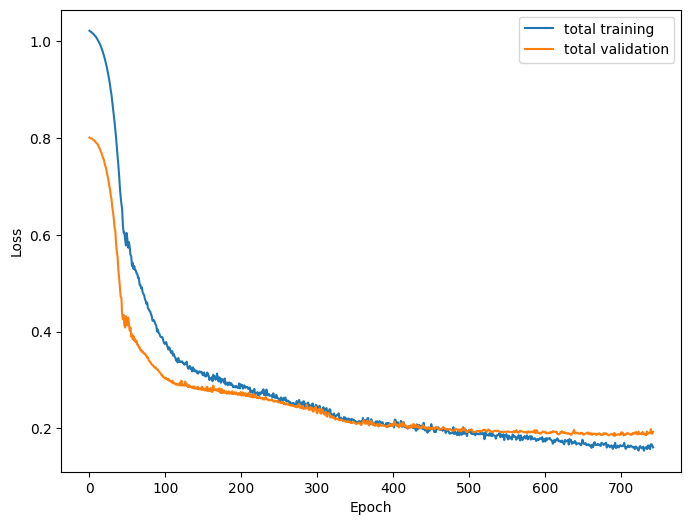

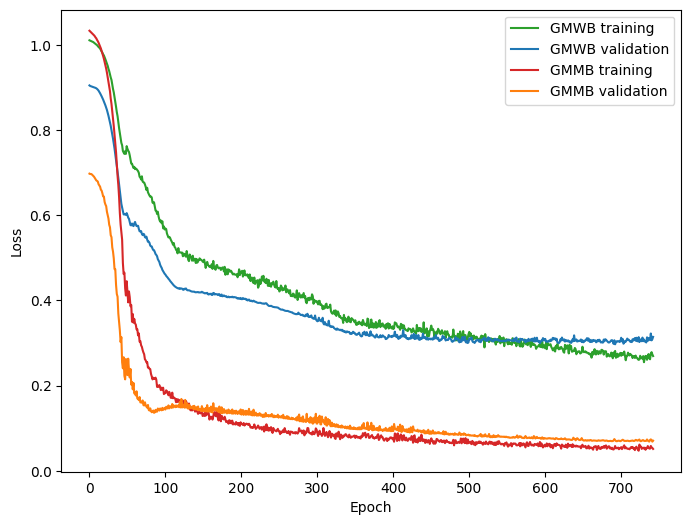

In [8]:
figure_path = "./figuresP3/"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# save the history
import pandas as pd

history = pd.read_csv("./history.csv")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='multi-task training')
plt.plot(history['val_loss'], label='multi-task validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig(figure_path + "figure5a.png")

plt.figure(figsize=(8, 6))
plt.plot(history['dense_89_loss'], label='GMWB training', color='tab:green')
plt.plot(history['val_dense_89_loss'], label='GMWB validation', color='tab:blue')
plt.plot(history['dense_91_loss'], label='GMMB training', color='tab:red')
plt.plot(history['val_dense_91_loss'], label='GMMB validation', color='tab:orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig(figure_path + "figure5b.png")

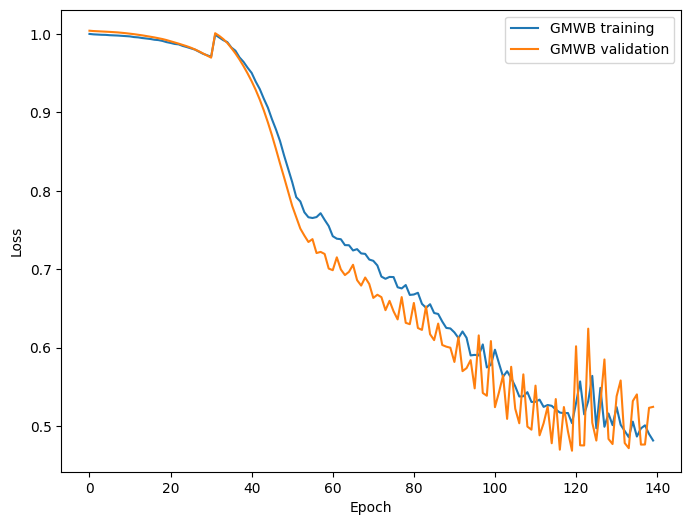

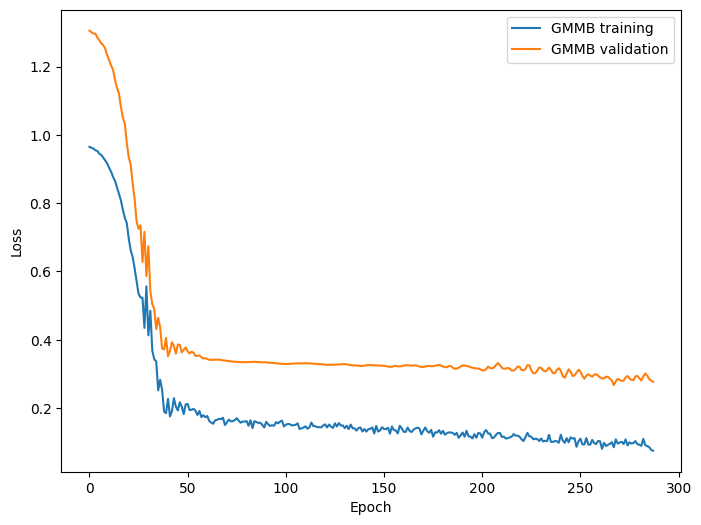

In [99]:
history_GMWB = pd.read_csv("./trainedModels/GMWB_PY/nolapse/LSTM_LoCap_LowNoise_nolapse_1000/training_history.csv")

plt.figure(figsize=(8, 6))
plt.plot(history_GMWB['loss'], label='GMWB training')
plt.plot(history_GMWB['val_loss'], label='GMWB validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig(figure_path + "figure6a.png")

history_GMMB = pd.read_csv("./trainedModels/GMMB_PY/nolapse/LSTM_LoCap_LowNoise_2000/training_history.csv")

plt.figure(figsize=(8, 6))
plt.plot(history_GMMB['loss'], label='GMMB training')
plt.plot(history_GMMB['val_loss'], label='GMMB validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig(figure_path + "figure6b.png")

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define shared LSTM layers
def build_shared_lstm(input_shape):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.LSTM(128, return_sequences=False)(inputs)
    return inputs, x

# Define task-specific fully connected layers
def task_specific_layers(shared_output, num_classes):
    x = layers.Dense(64, activation='relu')(shared_output)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return output

# Input shape (for example, 100 time steps and 1 feature per time step)
input_shape = (100, 1)

# Shared LSTM layers (one shared input and shared output)
inputs, shared_output = build_shared_lstm(input_shape)

# Define task-specific outputs
output_task_1 = task_specific_layers(shared_output, num_classes=5)  # Task 1 (e.g., 5 classes)
output_task_2 = task_specific_layers(shared_output, num_classes=3)  # Task 2 (e.g., 3 classes)
output_task_3 = task_specific_layers(shared_output, num_classes=4)  # Task 3 (e.g., 4 classes)

# Create the model with one shared input and three task-specific outputs
model = models.Model(inputs=inputs, outputs=[output_task_1, output_task_2, output_task_3])

# Compile the model with task-specific losses
model.compile(optimizer='adam',
              loss=['sparse_categorical_crossentropy', 
                    'sparse_categorical_crossentropy', 
                    'sparse_categorical_crossentropy'],
              metrics=['accuracy'])

# Prepare the data
# x_train: (2000 samples, 100 time steps, 1 feature)
# Each y_train corresponds to a specific task
x_train = tf.random.normal((2000, 100, 1))  # Input: 2000 samples, 100 time steps, 1 feature per time step
y_train_1 = tf.random.uniform((2000,), minval=0, maxval=5, dtype=tf.int32)  # Task 1 labels (5 classes)
y_train_2 = tf.random.uniform((2000,), minval=0, maxval=3, dtype=tf.int32)  # Task 2 labels (3 classes)
y_train_3 = tf.random.uniform((2000,), minval=0, maxval=4, dtype=tf.int32)  # Task 3 labels (4 classes)

# Train the model with shared input and task-specific outputs
model.fit(x_train, [y_train_1, y_train_2, y_train_3], epochs=10, batch_size=32)


ValueError: Invalid dtype: tuple

In [57]:
import numpy as np

target_contract = "GMMB"
target_lapse = "nolapse"

cwd = f"../sim_VA/result/{target_contract}/{target_lapse}/"

price = np.load(cwd + f"outerScenarios_{target_contract}_RS_{target_lapse}.npy")



In [67]:
target_contract = "GMWB"
target_lapse = "nolapse"

cwd1 = f"../sim_VA/result/{target_contract}/{target_lapse}/outerScenarios_GMWB_RS_{target_lapse}.npy"

price1 = np.load(cwd1)

cwd2 = "../sim_VA/result/GMWB/nolapse/outerScenarios_GMWB_RS_1000_.npy"

price2 = np.load(cwd)

cwd3 = "../sim_VA/result/GMWB/dlapse/outerScenarios_GMWB_RS_dlapse.npy"

price3 = np.load(cwd3)


In [71]:
a = np.abs(price1 - price3)



array([0.00000000e+00, 2.00088834e-11, 2.50111043e-12, ...,
       1.29602995e-11, 0.00000000e+00, 1.81898940e-12])

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Input layers for each task (assuming different input shapes)
input_task1 = tf.keras.Input(shape=(100, 1), name='input_task1')
input_task2 = tf.keras.Input(shape=(100, 1), name='input_task2')
input_task3 = tf.keras.Input(shape=(100, 1), name='input_task3')

# Shared LSTM layer
shared_lstm = layers.LSTM(units=128, return_sequences=False, name='shared_lstm')

# Apply shared LSTM to each task's input
shared_output_task1 = shared_lstm(input_task1)
shared_output_task2 = shared_lstm(input_task2)
shared_output_task3 = shared_lstm(input_task3)

# Task-specific fully connected layers
# Task 1
task1_dense = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='task1_dense')(shared_output_task1)
task1_output = layers.Dense(1, activation='relu', name='task1_output')(task1_dense)

# Task 2
task2_dense = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='task2_dense')(shared_output_task2)
task2_output = layers.Dense(1, activation='relu', name='task2_output')(task2_dense)

# Task 3
task3_dense = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='task3_dense')(shared_output_task3)
task3_output = layers.Dense(1, activation='relu', name='task3_output')(task3_dense)

# Create model with separate inputs and outputs
model = tf.keras.Model(inputs=[input_task1, input_task2, input_task3], 
                       outputs=[task1_output, task2_output, task3_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'task1_output': 'mean_squared_error',
                    'task2_output': 'mean_squared_error',
                    'task3_output': 'mean_squared_error'},
              metrics=["mean_squared_error",
                       "mean_squared_error",
                        "mean_squared_error"])

# Summary of the model
model.summary()

x_train = tf.random.normal((2000, 100, 1))  # Input: 2000 samples, 100 time steps, 1 feature per time step
y_train_1 = tf.random.normal((2000, 1))
y_train_2 = tf.random.normal((2000, 1))
y_train_3 = tf.random.normal((2000, 1))

# Assuming you have prepared different training data for each task
history = model.fit([x_train, x_train, x_train],  # Inputs for each task
                    [y_train_1, y_train_2, y_train_3],  # Labels for each task
                    epochs=10, batch_size=32, validation_split=0.2)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_task1         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_task2         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_task3         │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm (LSTM)  │ (None, 128)       │     66,560 │ input_task1[0][0… │
│                     │                   │            │ input_task2[0][0… │
│                     │                   │            │ input_task3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task1_dense (Dense) │ (None, 64)        │      8,256 │ shared_lstm[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task2_dense (Dense) │ (None, 64)        │      8,256 │ shared_lstm[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task3_dense (Dense) │ (None, 64)        │      8,256 │ shared_lstm[2][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task1_output        │ (None, 1)         │         65 │ task1_dense[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task2_output        │ (None, 1)         │         65 │ task2_dense[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task3_output        │ (None, 1)         │         65 │ task3_dense[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,523 (357.51 KB)

 Trainable params: 91,523 (357.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 5.0852 - task1_output_loss: 1.0061 - task1_output_mean_squared_error: 1.0061 - task2_output_loss: 0.9960 - task2_output_mean_squared_error: 0.9960 - task3_output_loss: 0.9810 - task3_output_mean_squared_error: 0.9810 - val_loss: 3.9875 - val_task1_output_loss: 1.0405 - val_task1_output_mean_squared_error: 1.0099 - val_task2_output_loss: 0.9772 - val_task2_output_mean_squared_error: 0.9766 - val_task3_output_loss: 0.9558 - val_task3_output_mean_squared_error: 0.9571
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 3.8126 - task1_output_loss: 0.9830 - task1_output_mean_squared_error: 0.9830 - task2_output_loss: 0.9988 - task2_output_mean_squared_error: 0.9988 - task3_output_loss: 0.9934 - task3_output_mean_squared_error: 0.9934 - val_loss: 3.3168 - val_task1_output_loss: 1.0405 - val_task1_output_mean_squared_error: 1.0099 - val_task2_output_loss: 0.9676 - val_task2_output_mean_squared_error: 0.9663 - val_task3_output_